DATA SHAPE: (63293, 30)

--- MISSING VALUES (top 20) ---
Month               91
Phone               88
Shipping_Method     87
Gender              82
Email               80
Total_Amount        80
Date                79
Total_Purchases     78
Feedback            74
Ratings             74
Customer_ID         74
Payment_Method      72
Address             69
Time                69
Product_Category    69
Transaction_ID      66
Zipcode             65
Year                63
Product_Brand       61
Amount              57
dtype: int64

--- DESCRIPTIVE STATS (numerical) ---
                   count          mean           std           min  \
Transaction_ID   63227.0  5.498808e+06  2.588086e+06  1.000007e+06   
Customer_ID      63219.0  5.501262e+04  2.601389e+04  1.000100e+04   
Phone            63205.0  5.506312e+09  2.599312e+09  1.000061e+09   
Zipcode          63228.0  5.034095e+04  2.898732e+04  5.040000e+02   
Age              63290.0  2.133133e+01  4.681605e+00  1.800000e+01   
Year       

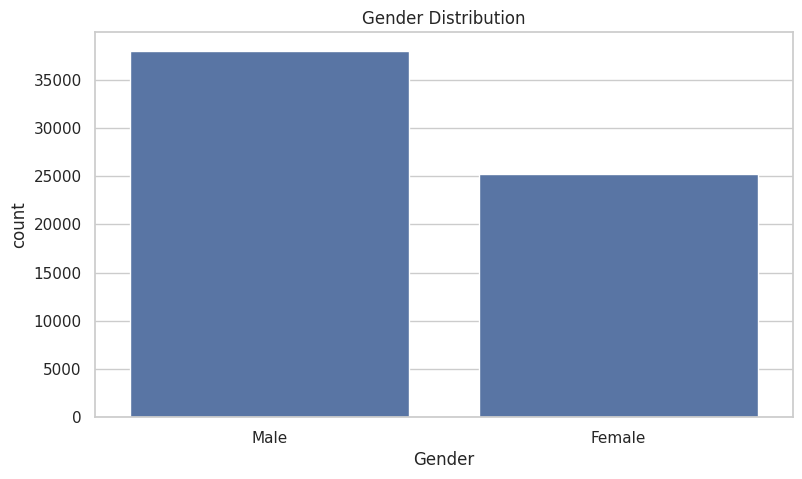

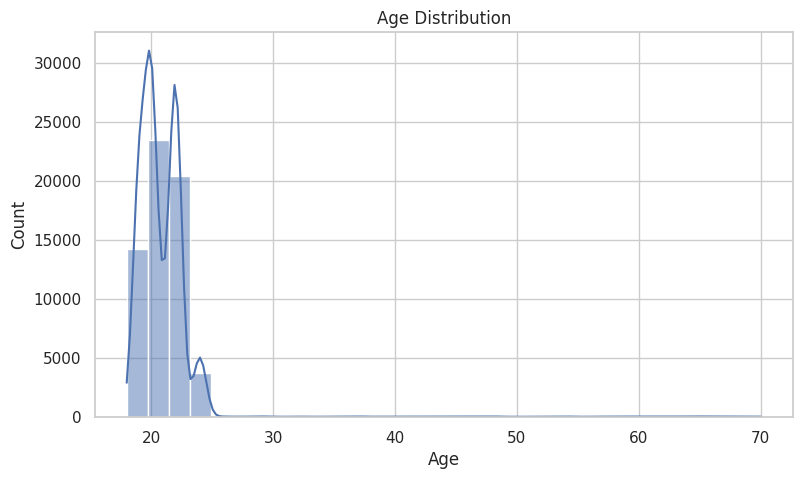

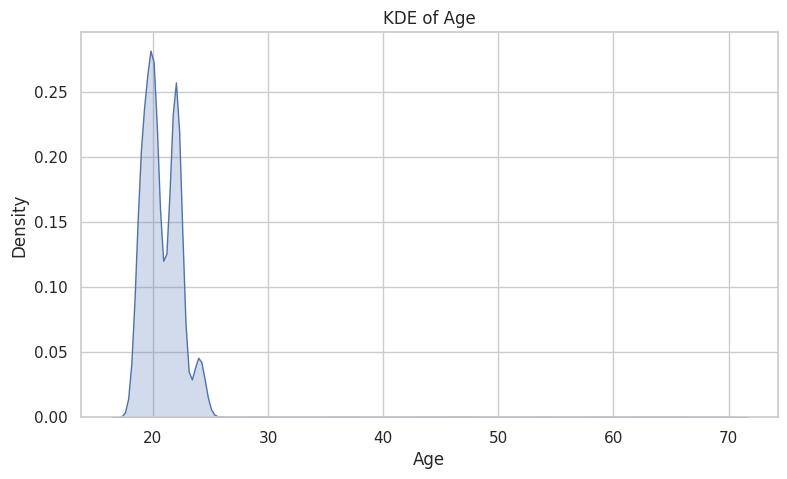

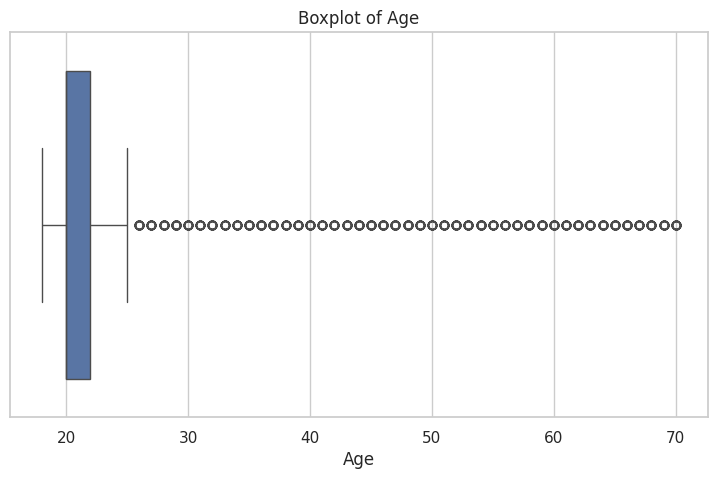

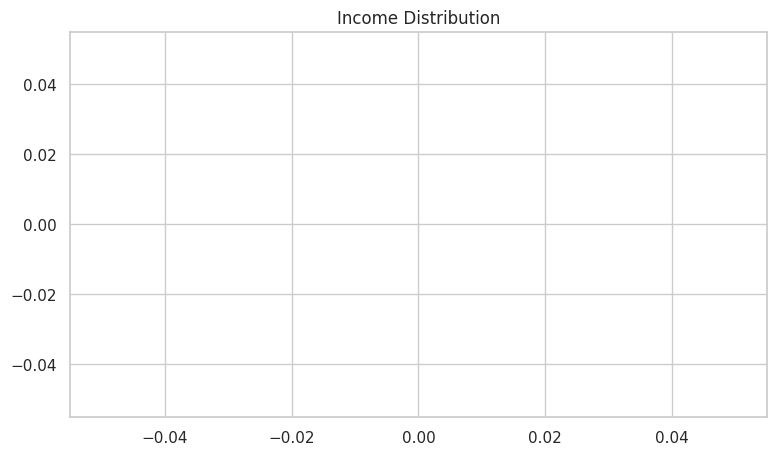

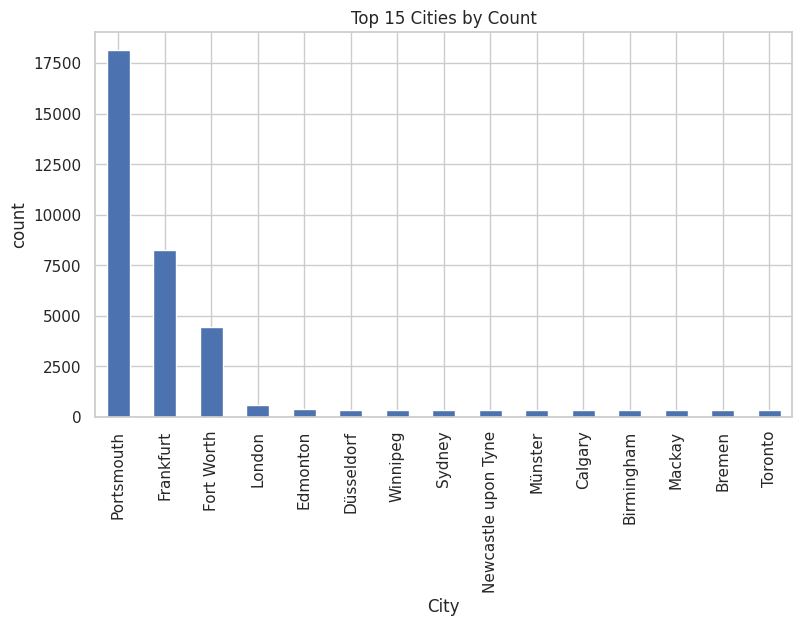

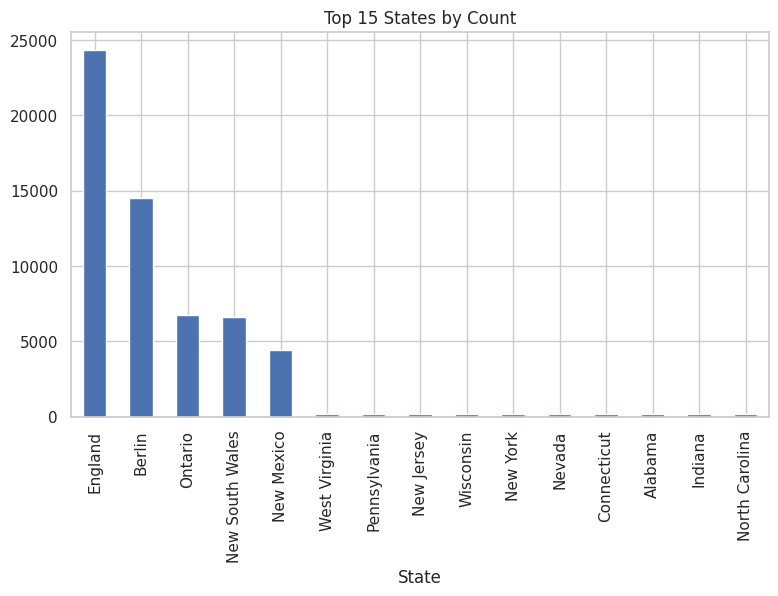

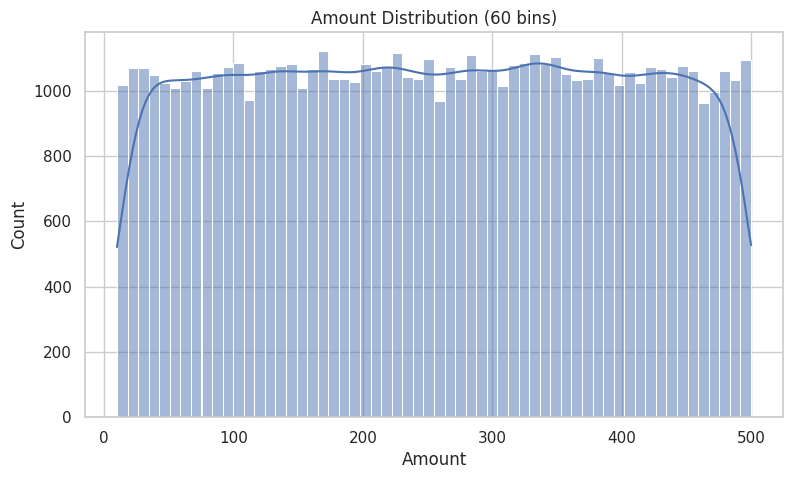

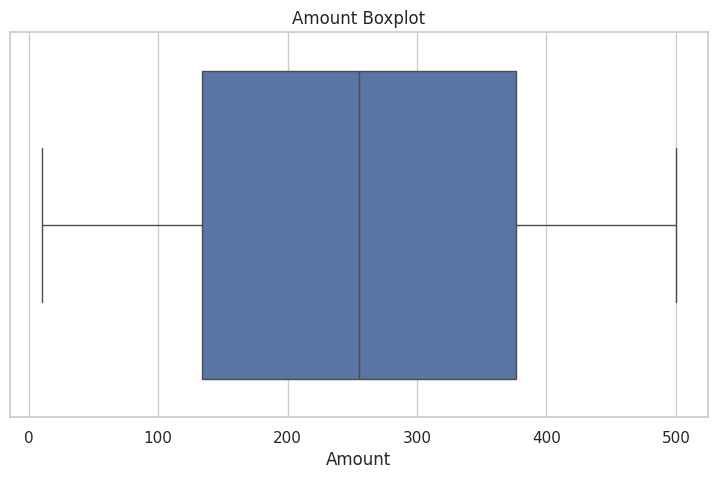

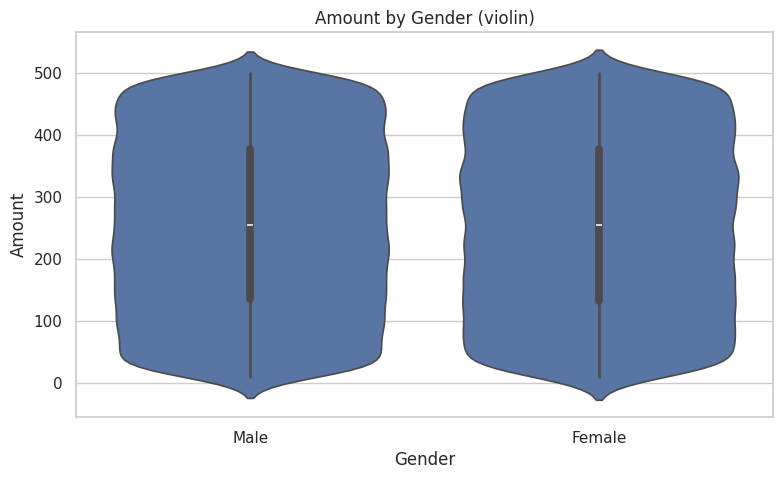

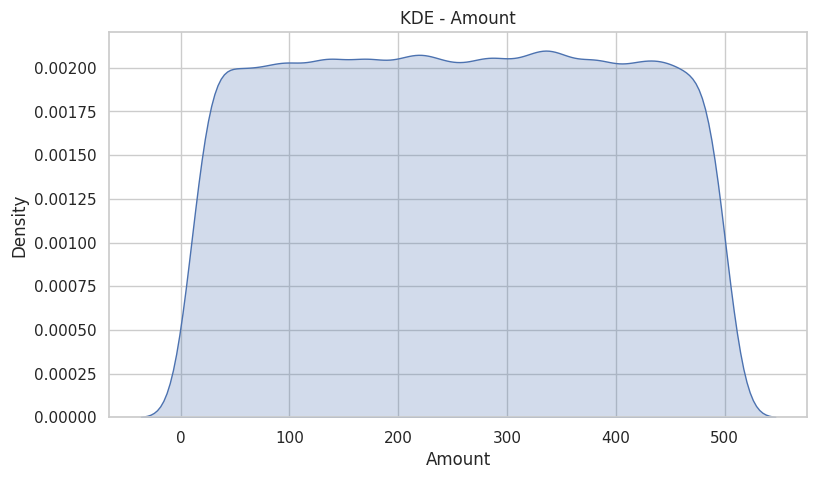

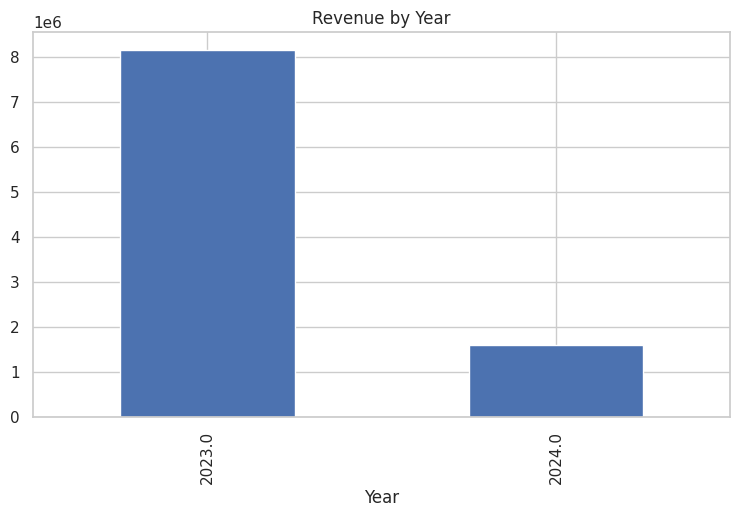

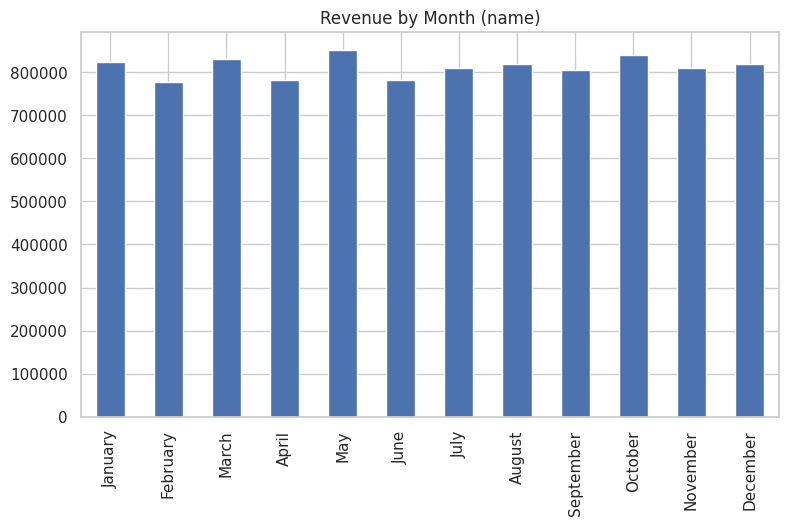

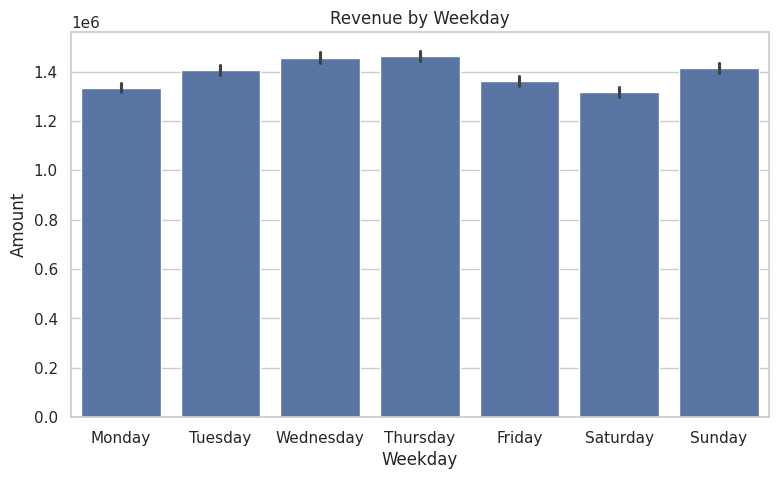

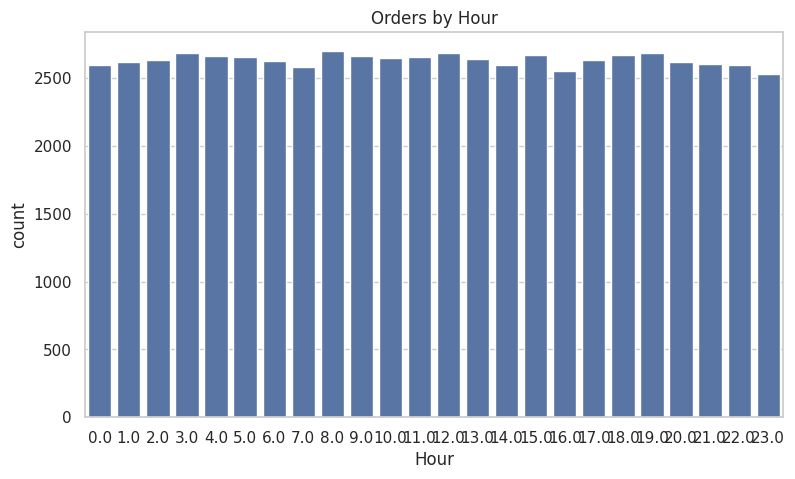

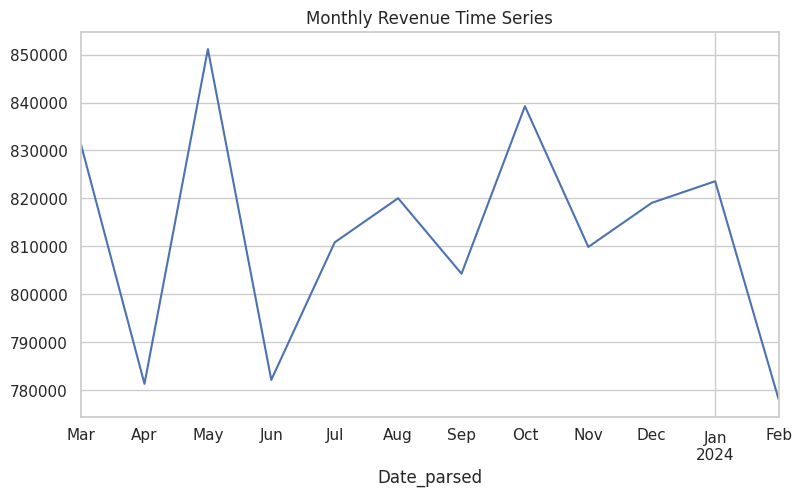

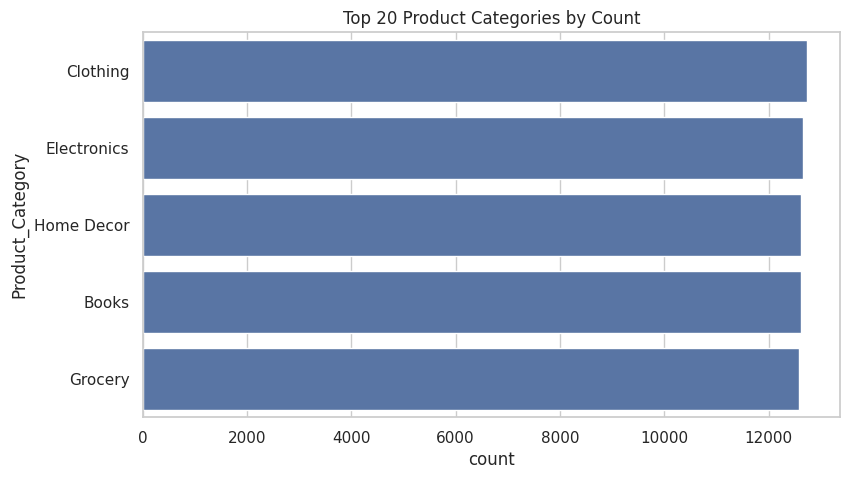

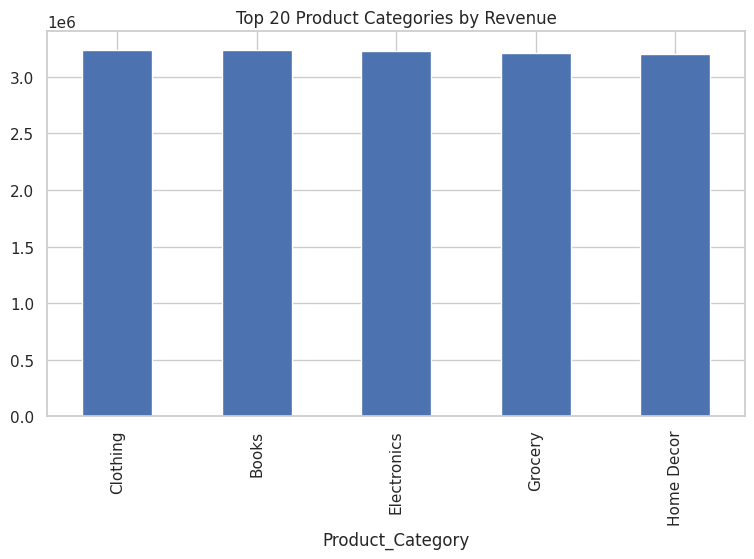

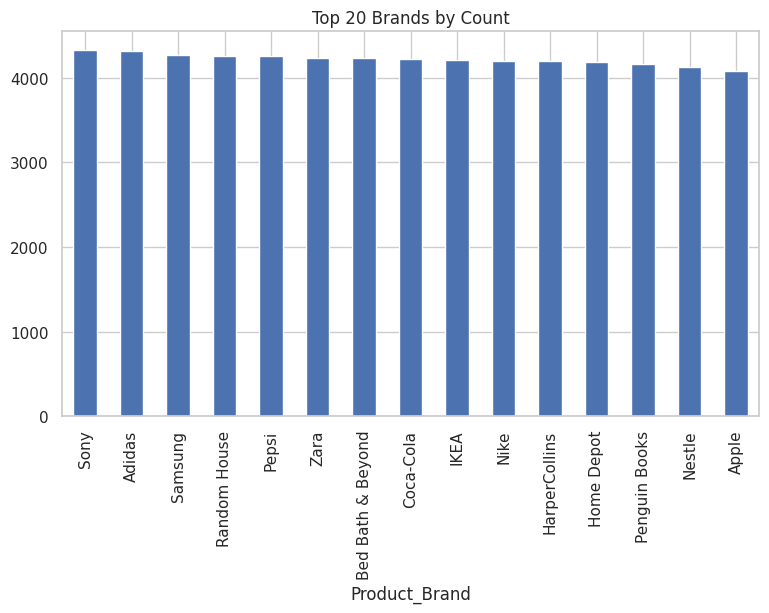

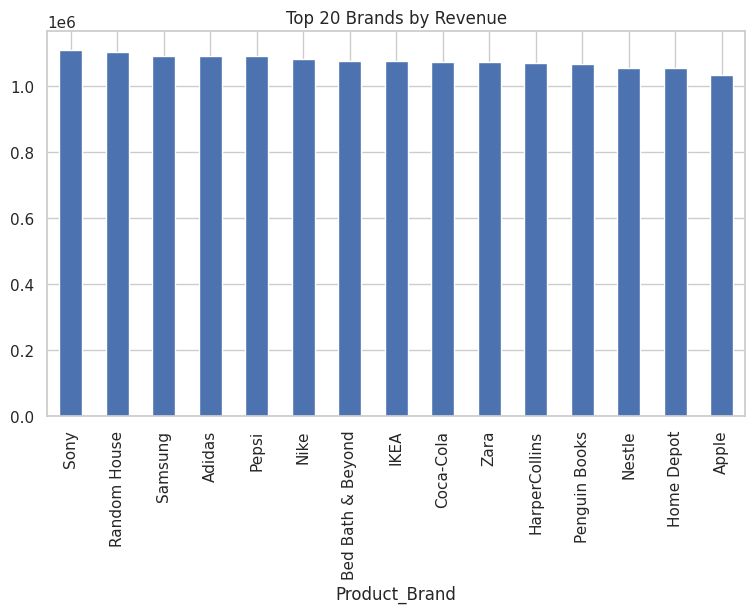

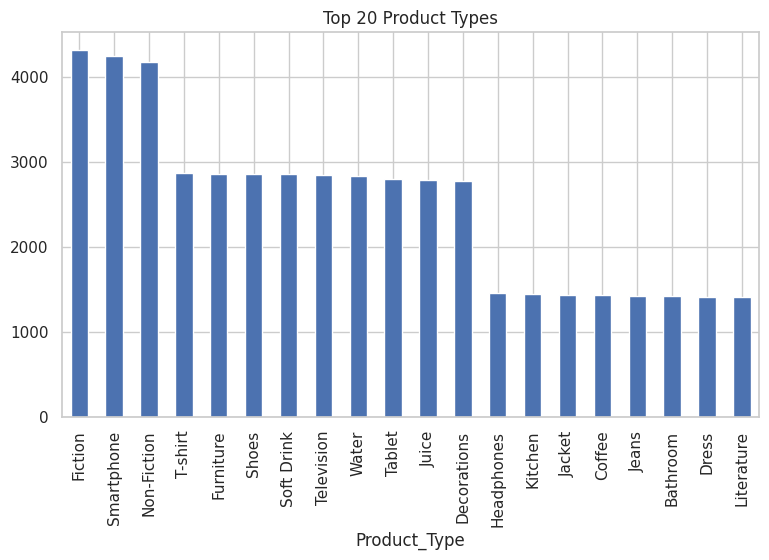

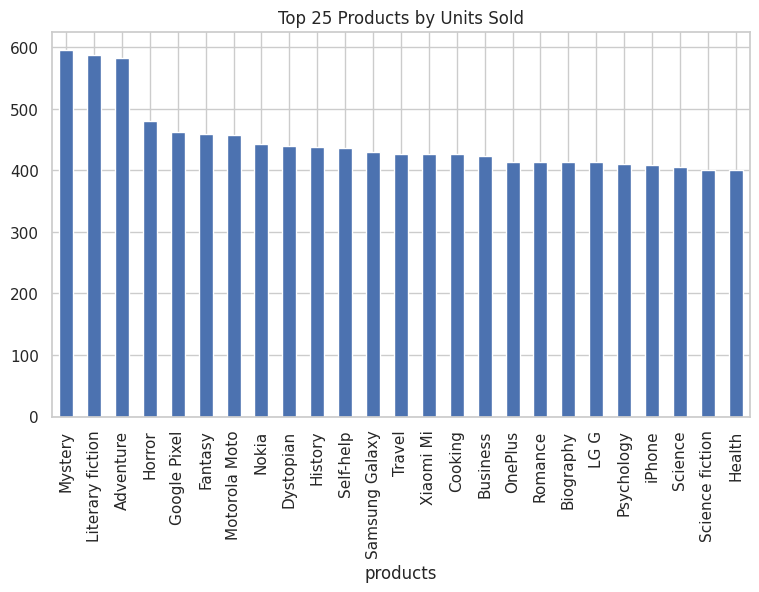

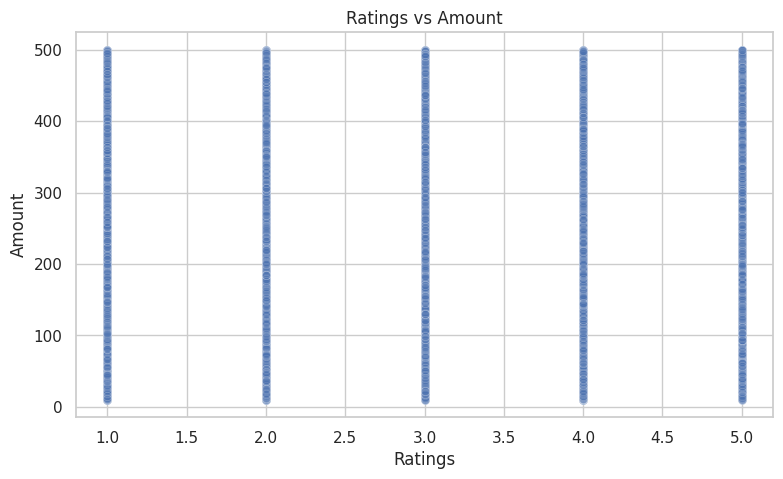

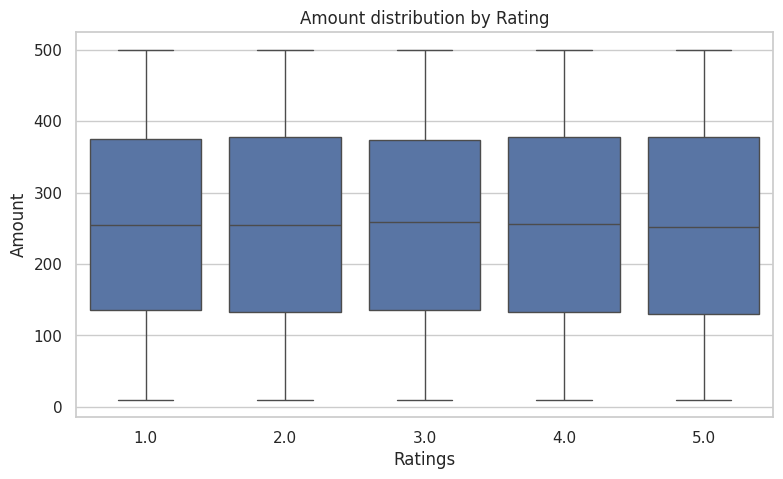

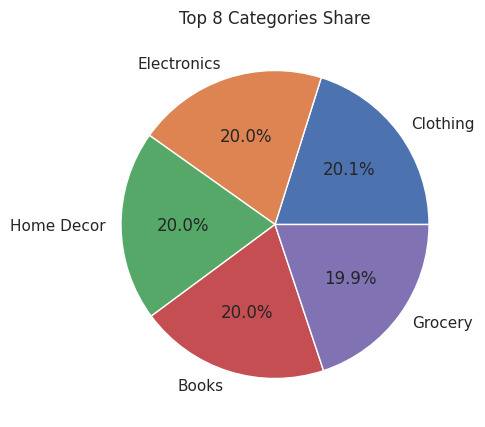

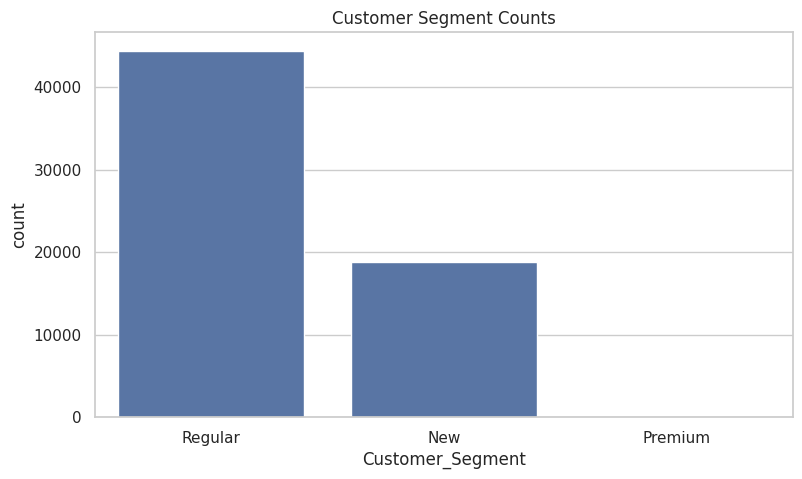

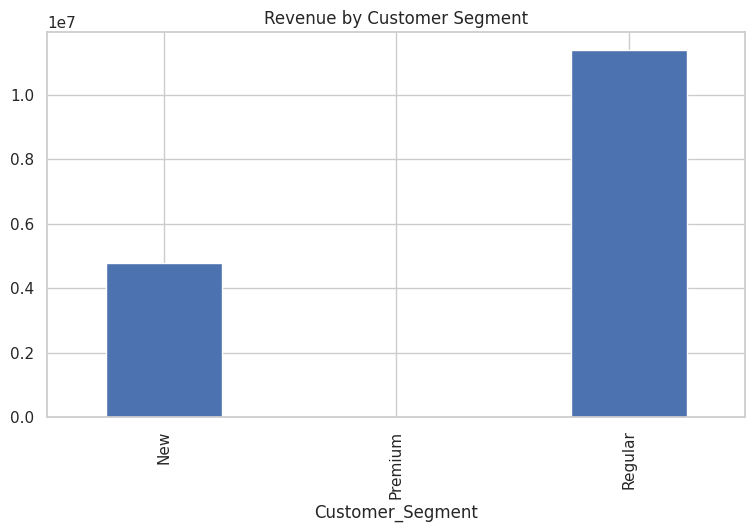

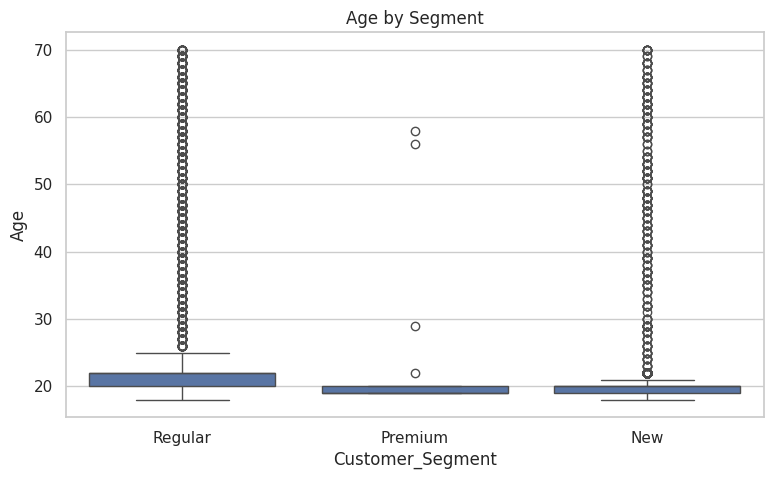

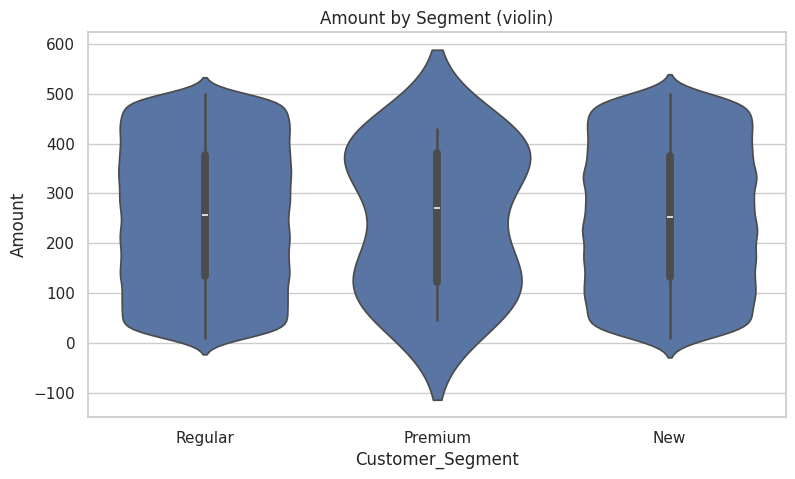

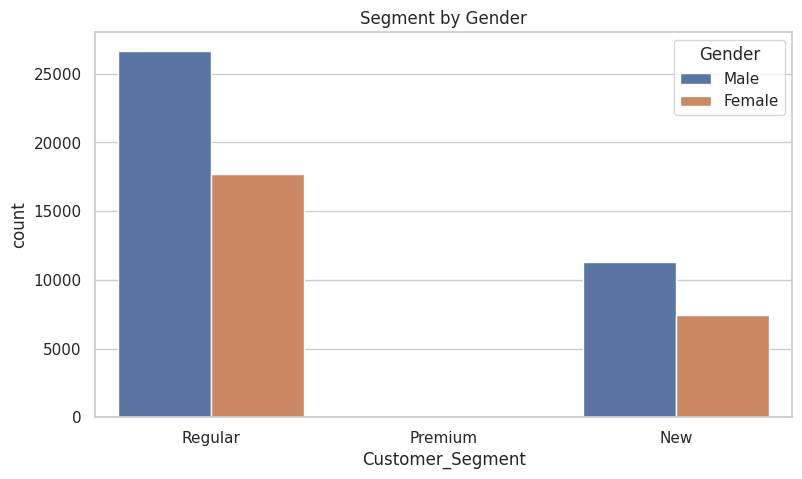

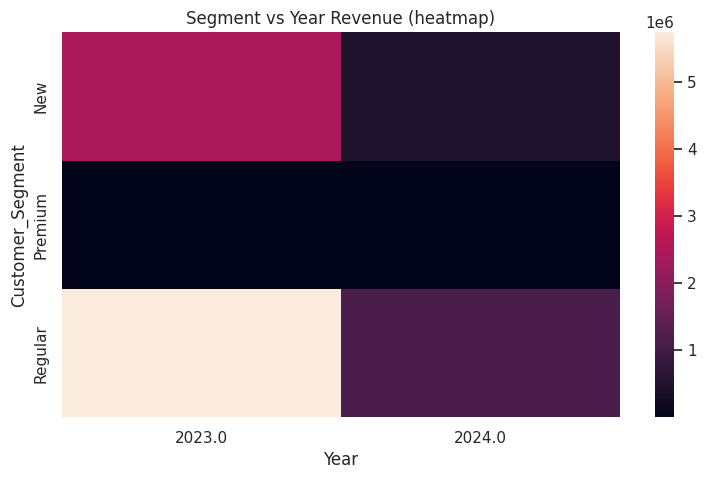

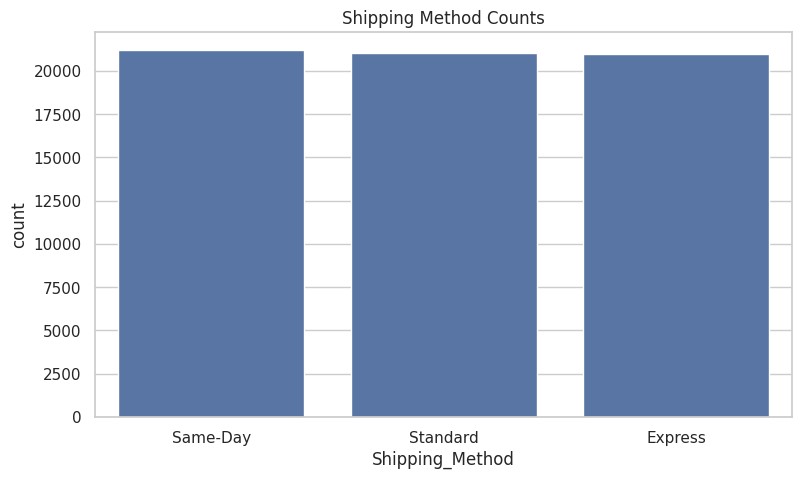

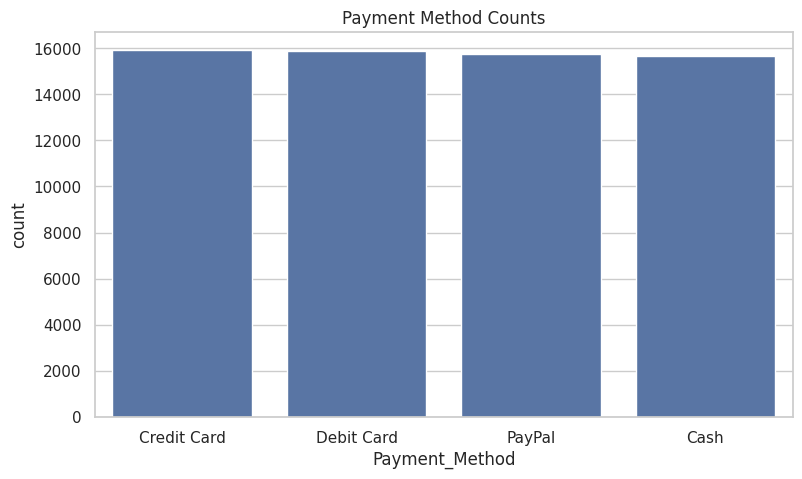

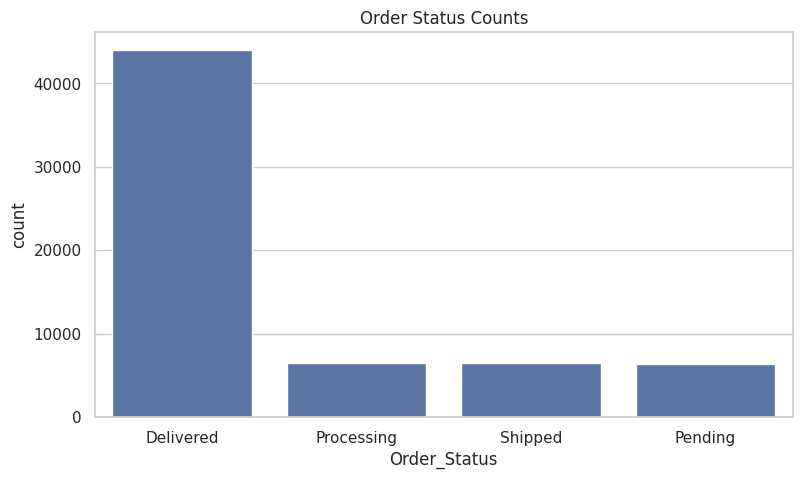

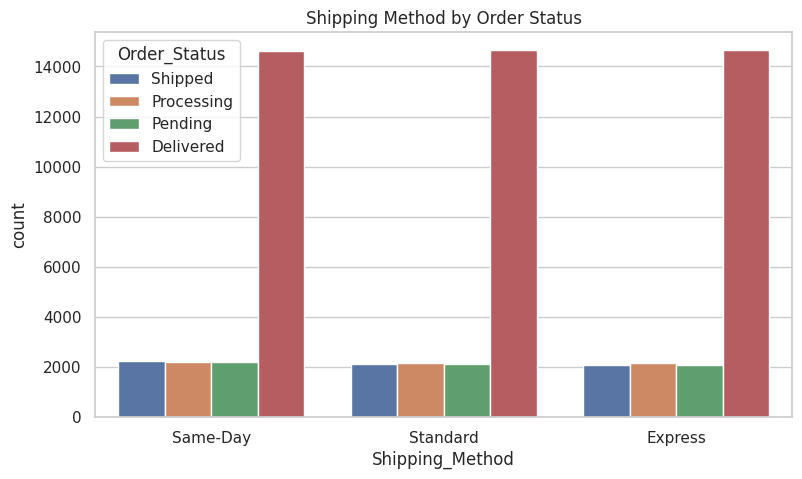

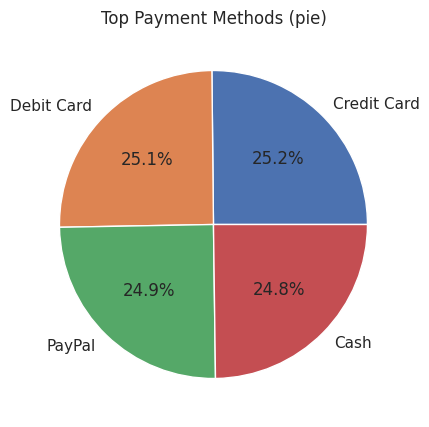

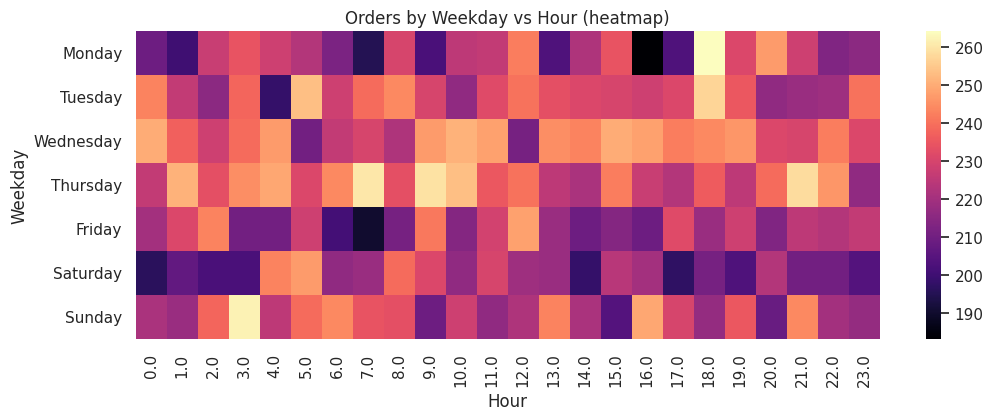

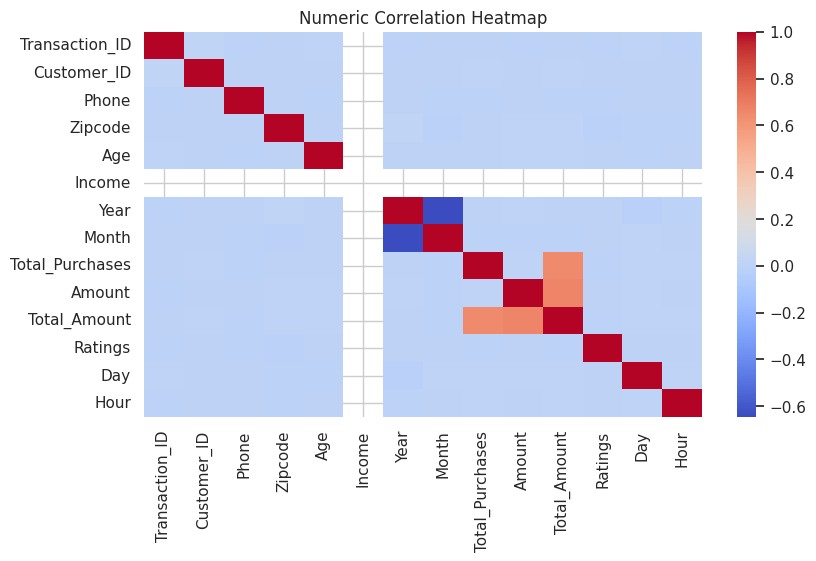

<Figure size 900x500 with 0 Axes>

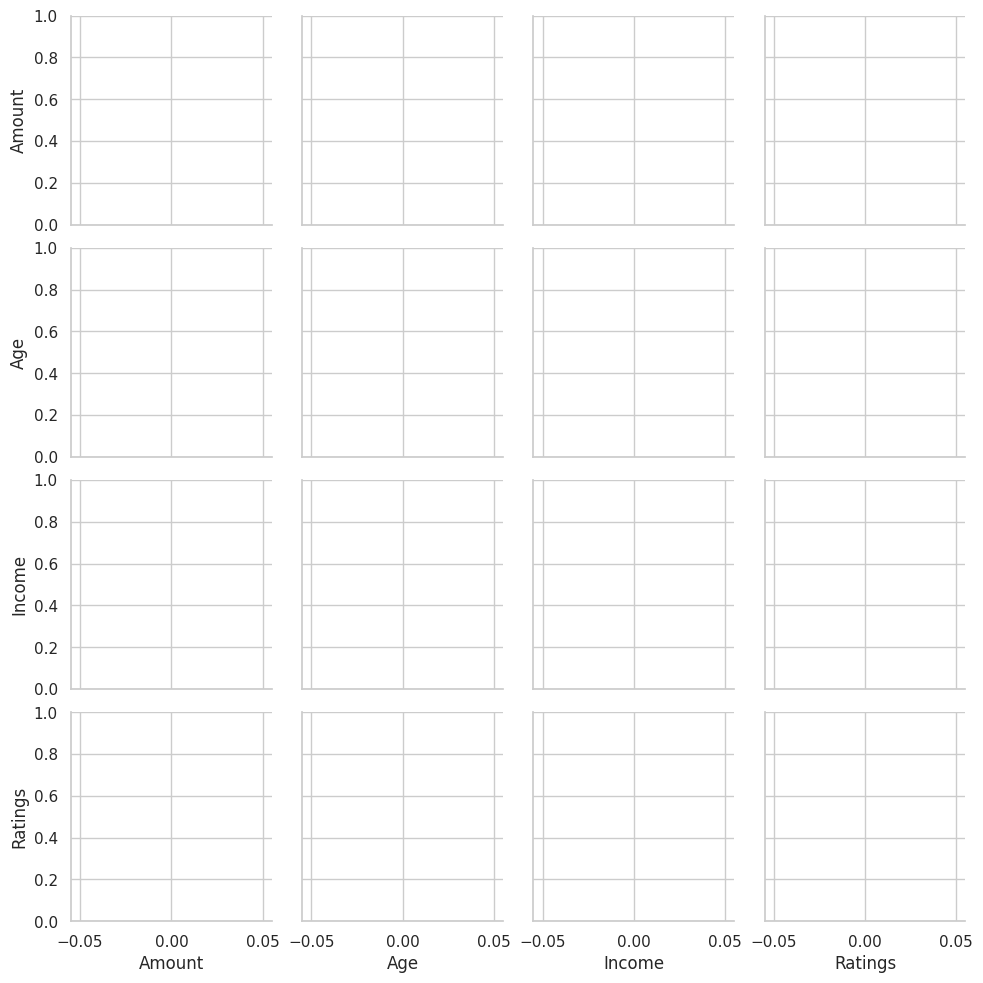

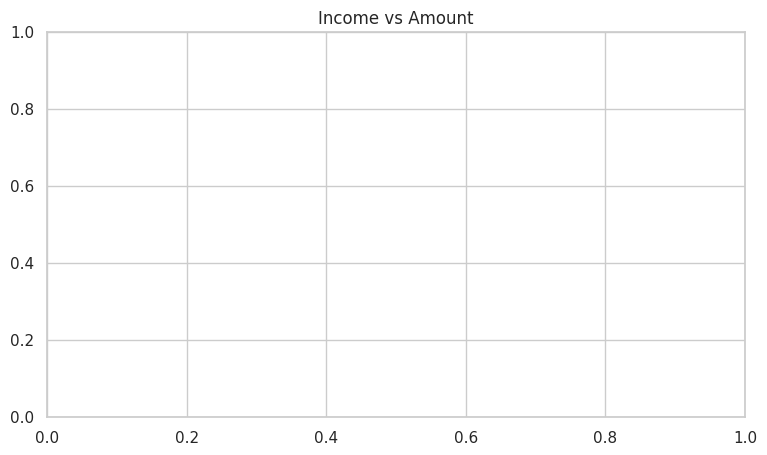

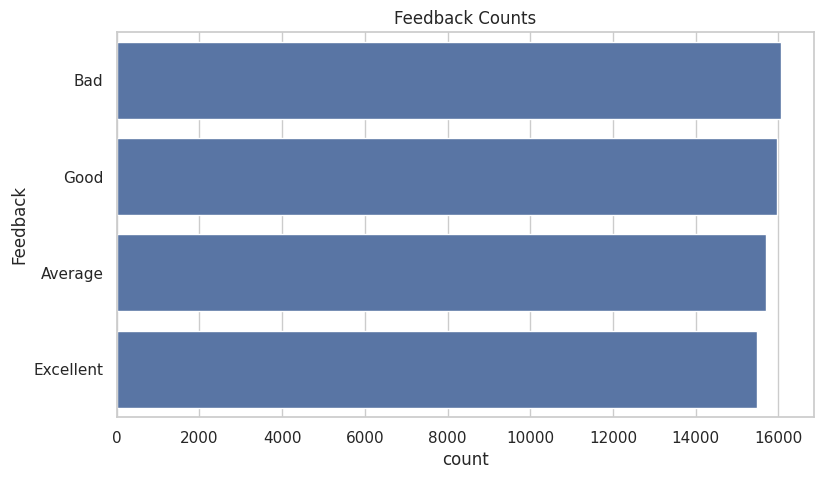

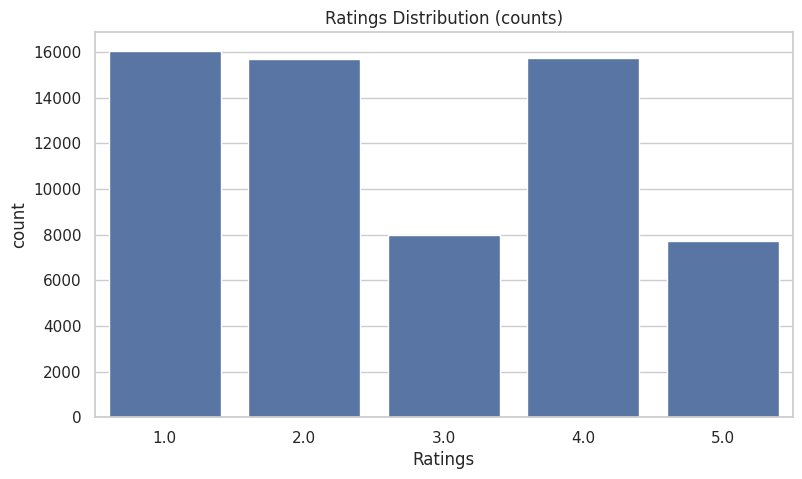

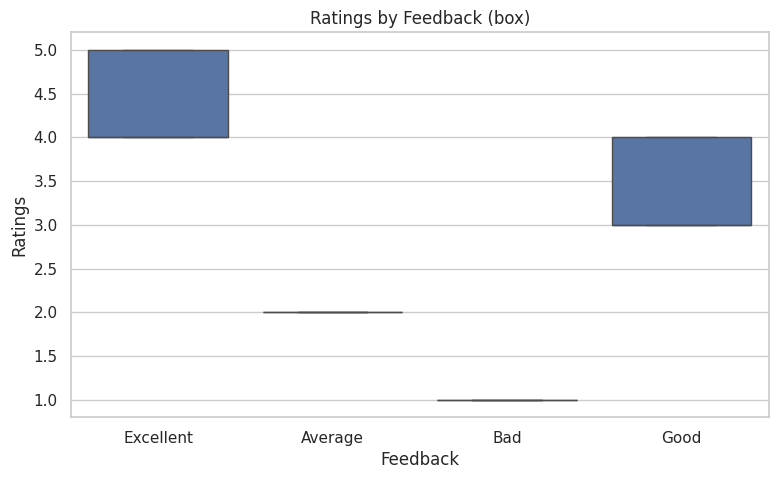

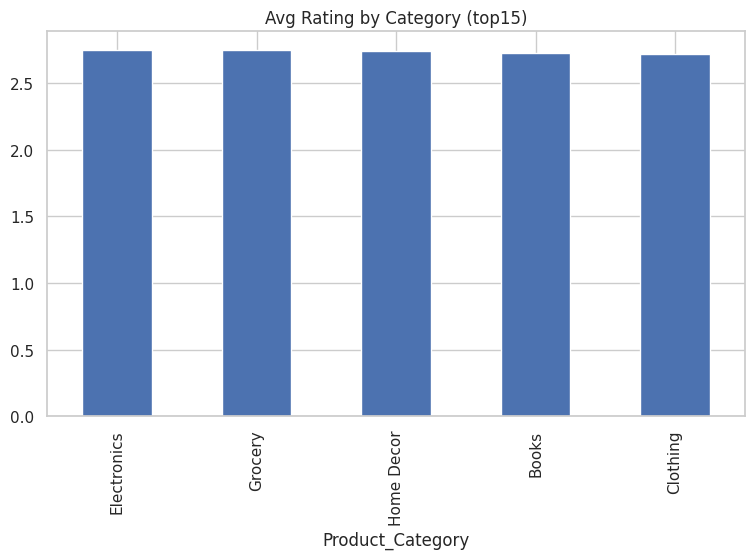

<Figure size 1200x500 with 0 Axes>

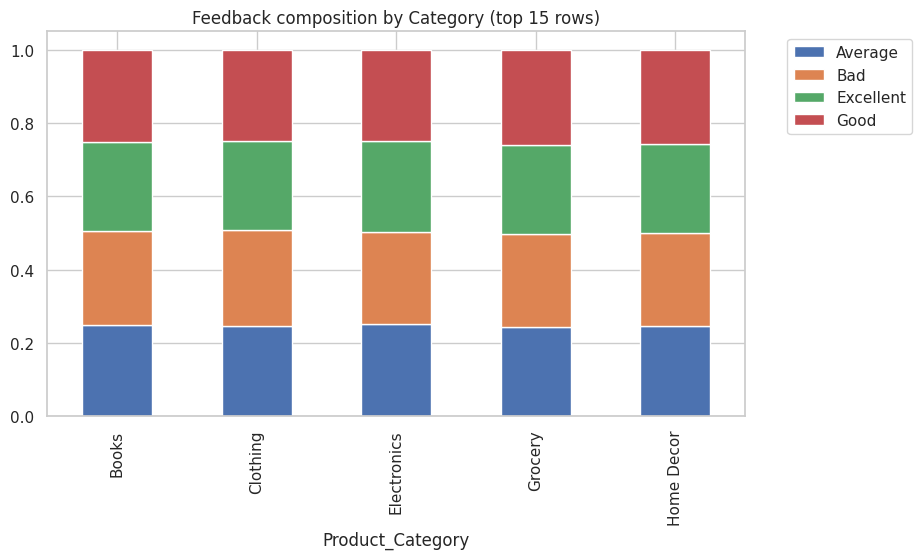


--- TOP 10 CUSTOMERS BY SPEND ---
 Customer_ID
53266.0    2140.877019
79759.0    1938.470057
39981.0    1865.738569
55824.0    1793.731106
61905.0    1787.176289
31385.0    1751.428082
24724.0    1735.626098
93921.0    1660.845465
42918.0    1629.764034
72352.0    1598.826160
Name: Amount, dtype: float64


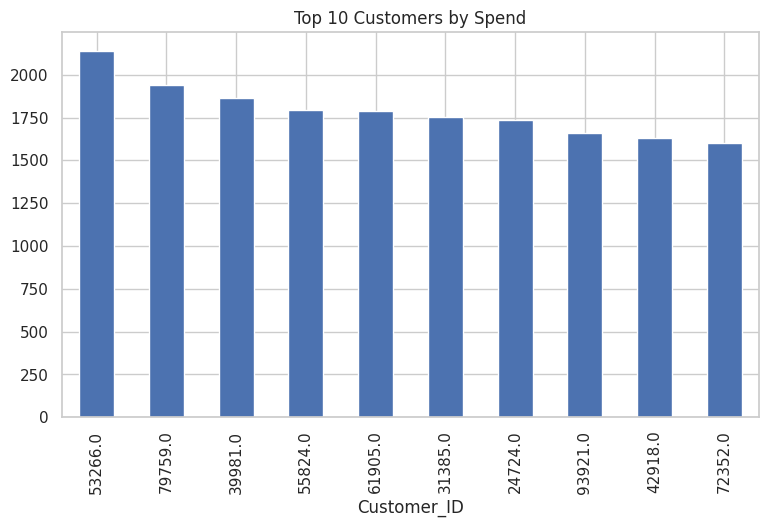

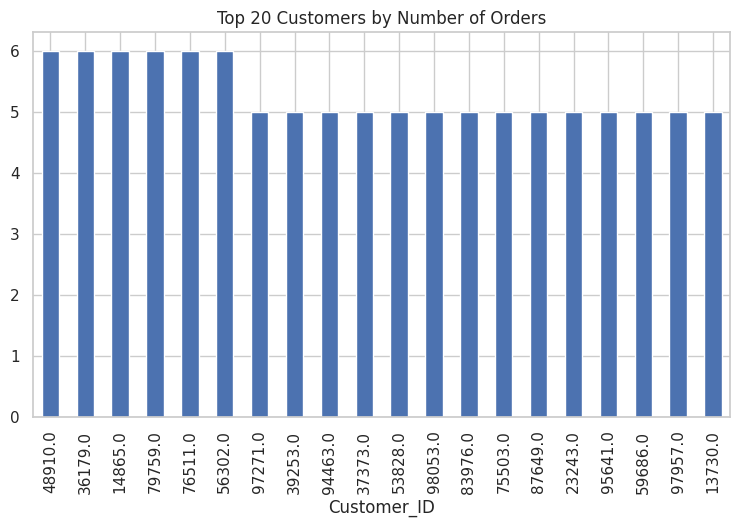


--- AVG ORDER VALUE BY CATEGORY (top 15) ---
 Product_Category
Books          256.656729
Grocery        255.700535
Electronics    255.259790
Clothing       254.665951
Home Decor     254.018807
Name: Amount, dtype: float64


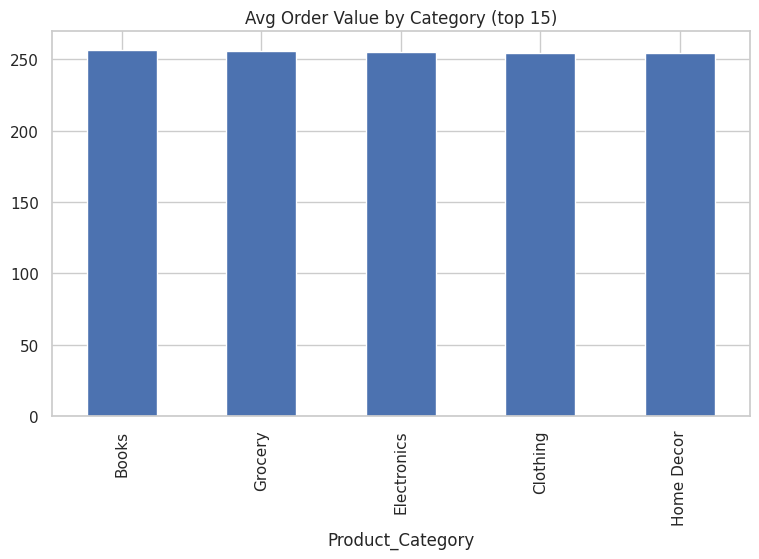

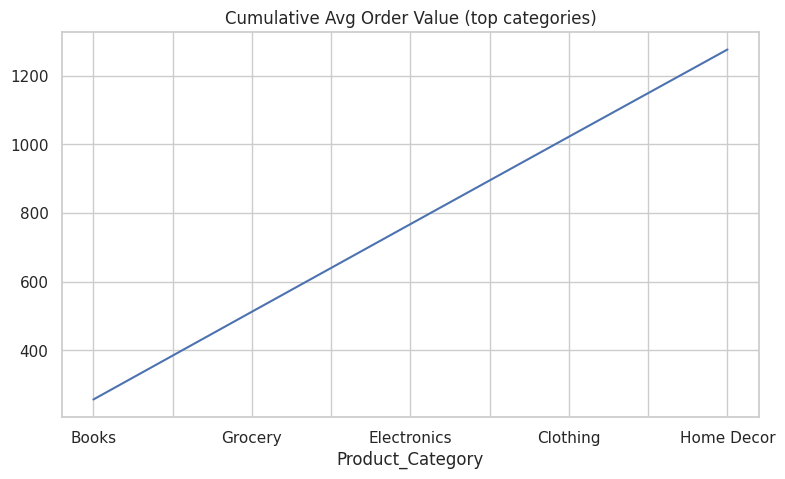


--- REVENUE PIVOT (Country x Year) - top 10 rows ---
 Year             2023.0         2024.0
Country                               
Australia  8.716879e+05  166456.474943
Canada     8.756834e+05  169259.751049
Germany    1.851039e+06  378058.830096
UK         3.121597e+06  613224.312994
USA        1.424158e+06  272590.360581


<Figure size 900x500 with 0 Axes>

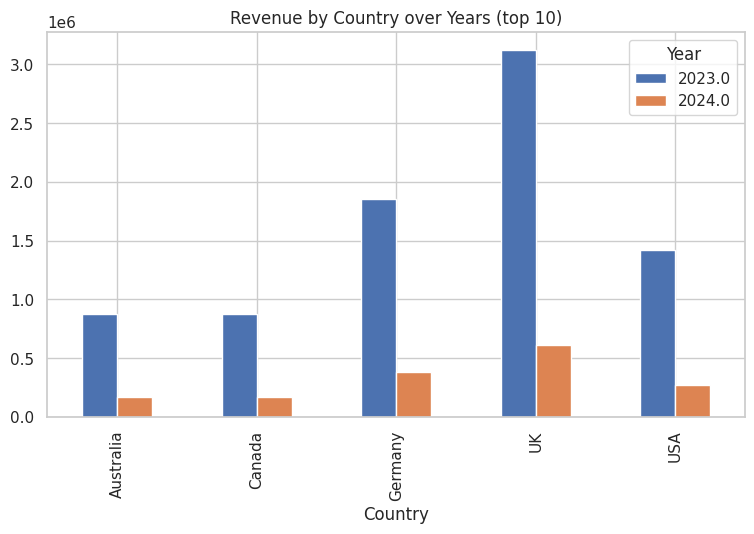

<Figure size 1200x500 with 0 Axes>

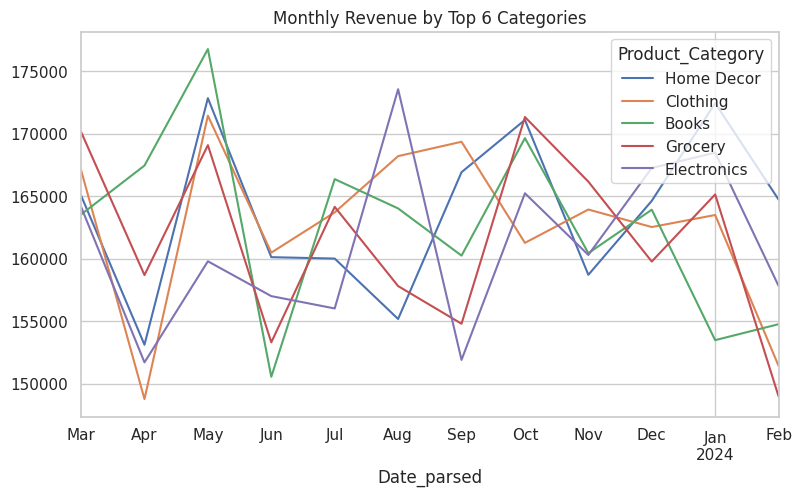

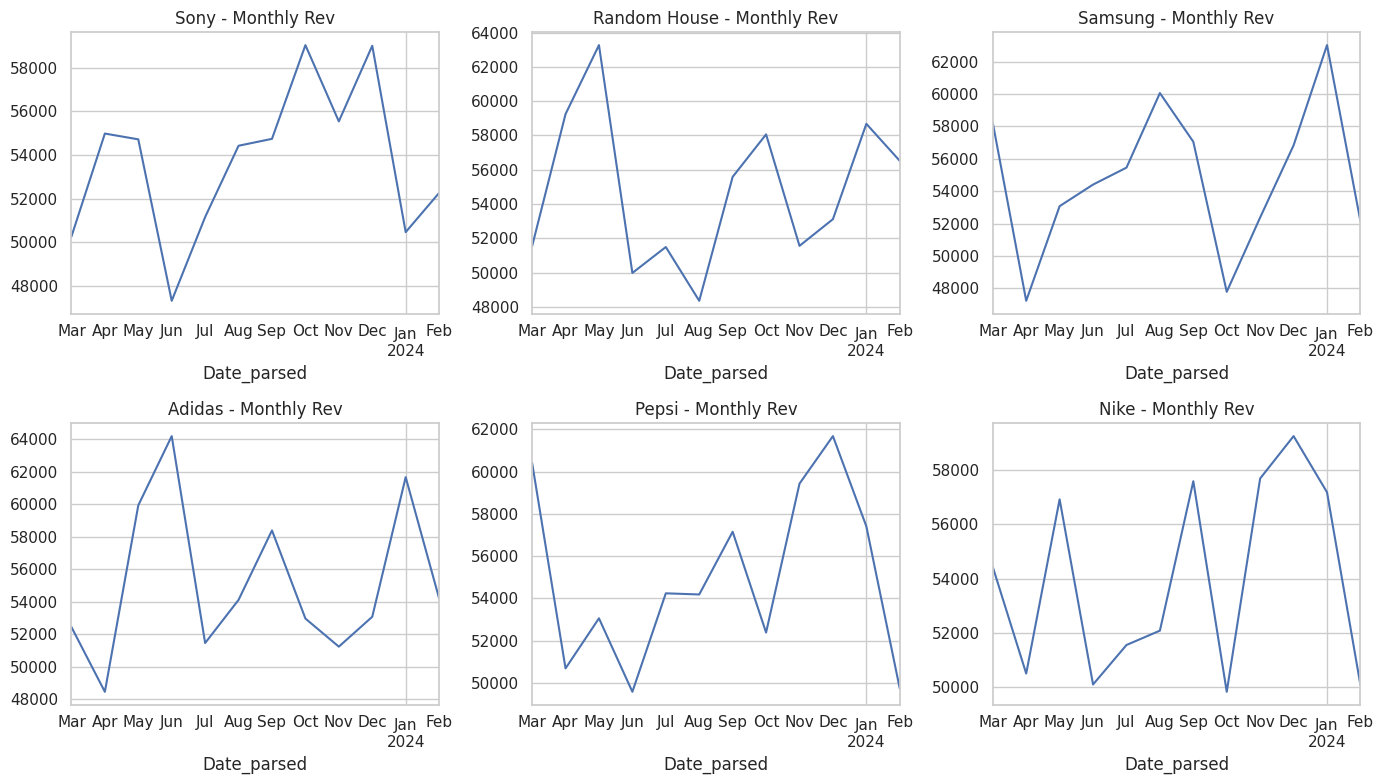

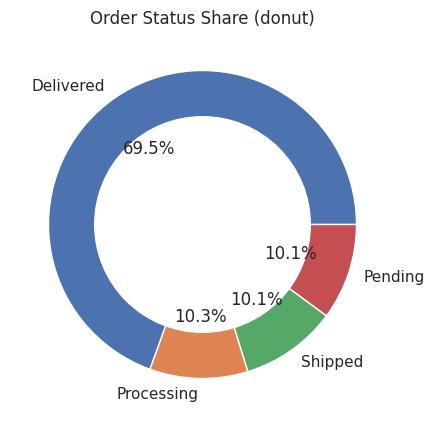

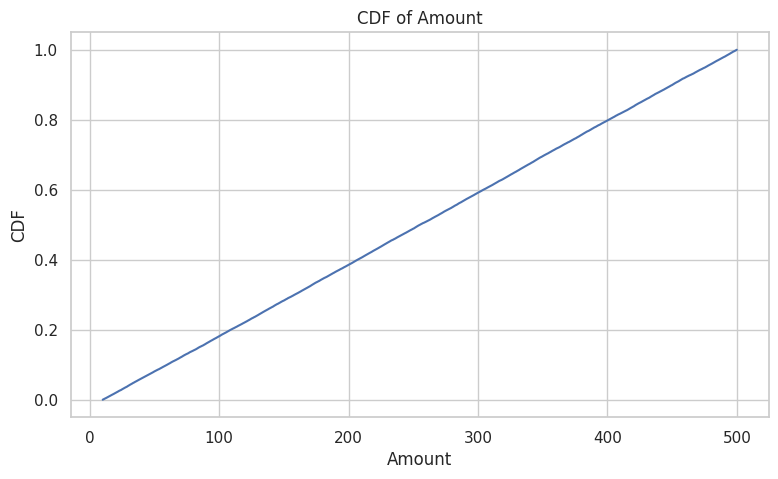

<Figure size 1000x500 with 0 Axes>

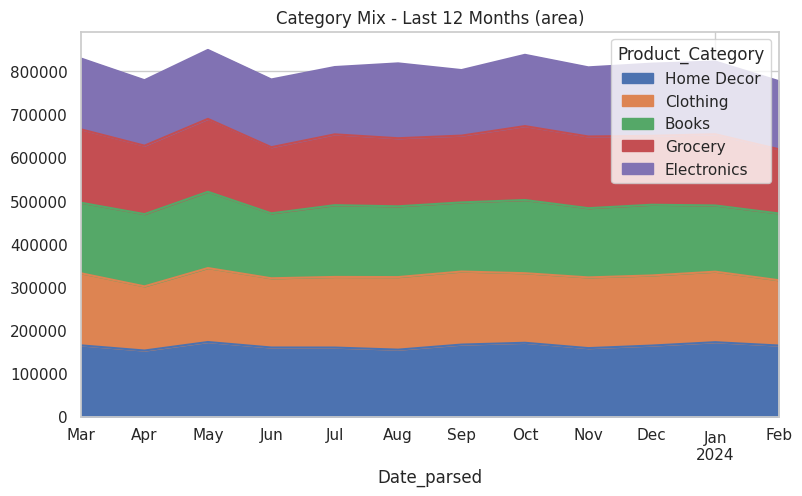

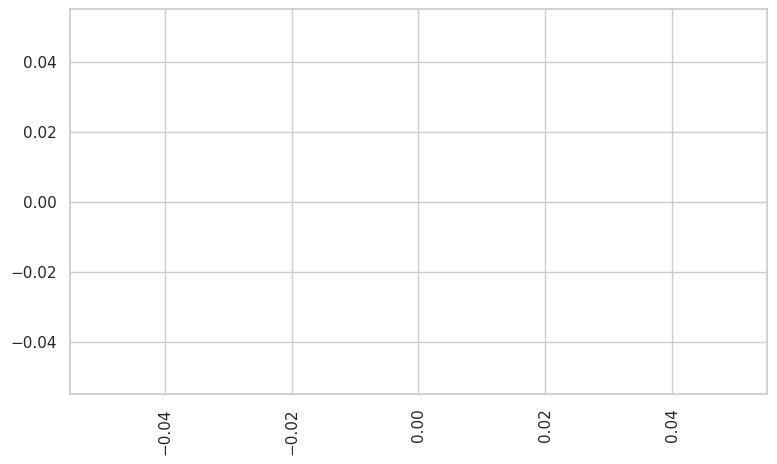

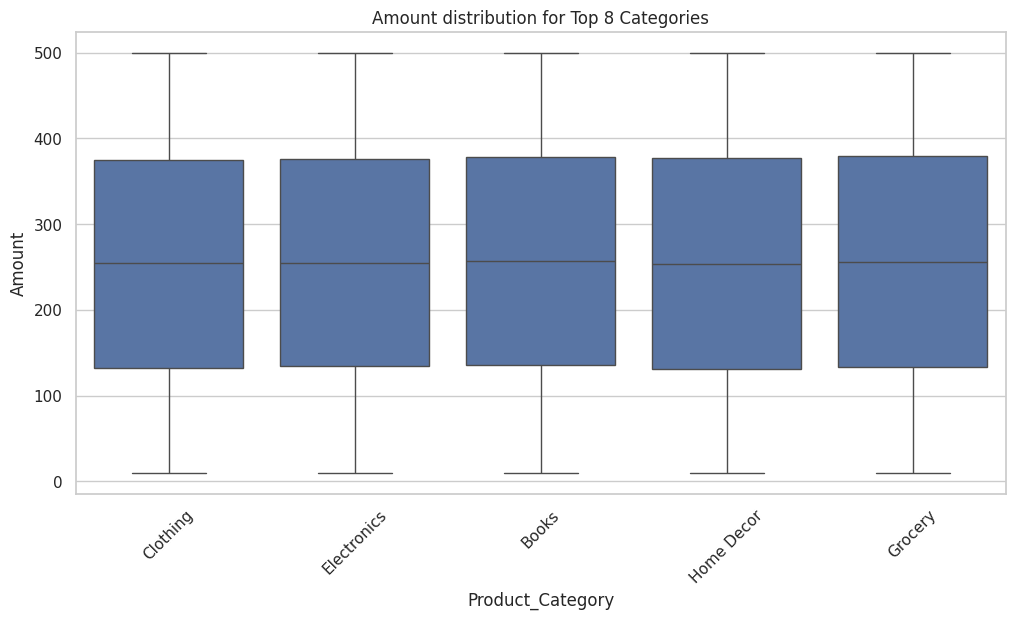

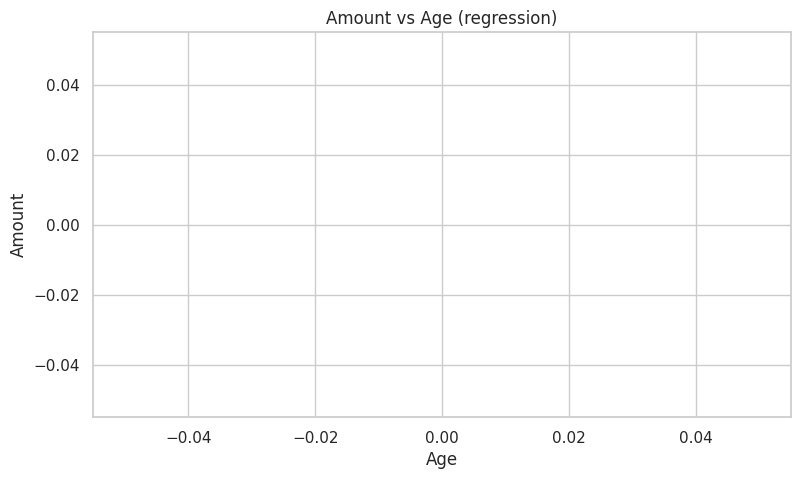


TOTAL PLOTS RENDERED (approx): 57  (should be 60+)

Done. Inspect the notebook output for all charts, printed tables and pivot summaries.


In [2]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)

# 0. Load
df = pd.read_csv("retail_data.csv")
print("DATA SHAPE:", df.shape)

# 1. Basic outputs
print("\n--- MISSING VALUES (top 20) ---")
print(df.isna().sum().sort_values(ascending=False).head(20))
print("\n--- DESCRIPTIVE STATS (numerical) ---")
print(df.describe().T)
print("\n--- DESCRIPTIVE STATS (categorical sample) ---")
print(df.describe(include=['object']).T.head(15))

# 2. Preprocessing helpers & create derived cols if possible
def safe_to_datetime(col):
    try:
        return pd.to_datetime(df[col], errors='coerce')
    except:
        return None

# Create Date, Year, Month, Day, Hour, Weekday
if 'Date' in df.columns:
    df['Date_parsed'] = pd.to_datetime(df['Date'], errors='coerce')
else:
    df['Date_parsed'] = pd.NaT

df['Year'] = df['Date_parsed'].dt.year
df['Month'] = df['Date_parsed'].dt.month
df['MonthName'] = df['Date_parsed'].dt.month_name()
df['Day'] = df['Date_parsed'].dt.day
df['Weekday'] = df['Date_parsed'].dt.day_name()
# Hour from Time if exists
if 'Time' in df.columns:
    df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour
else:
    df['Hour'] = np.nan

# Safe numeric conversions
for col in ['Amount', 'Age', 'Income', 'Ratings']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop exact duplicates (keep first)
pre_dedup = df.shape[0]
df = df.drop_duplicates()
print("\nDropped duplicates:", pre_dedup - df.shape[0])

# Helper to show and count plot index
plot_count = 0
def show():
    global plot_count
    plt.show()
    plot_count += 1

# --- DEMOGRAPHICS (8 plots) ---
if 'Gender' in df.columns:
    plt.figure(); sns.countplot(x='Gender', data=df, order=df['Gender'].value_counts().index); plt.title('Gender Distribution'); show()
if 'Age' in df.columns:
    plt.figure(); sns.histplot(df['Age'].dropna(), bins=30, kde=True); plt.title('Age Distribution'); show()
    plt.figure(); sns.kdeplot(df['Age'].dropna(), shade=True); plt.title('KDE of Age'); show()
    plt.figure(); sns.boxplot(x='Age', data=df); plt.title('Boxplot of Age'); show()
if 'Income' in df.columns:
    plt.figure(); sns.histplot(df['Income'].dropna(), bins=30, kde=True); plt.title('Income Distribution'); show()
if 'City' in df.columns:
    plt.figure(); df['City'].value_counts().head(15).plot(kind='bar'); plt.title('Top 15 Cities by Count'); plt.ylabel('count'); show()
if 'State' in df.columns:
    plt.figure(); df['State'].value_counts().head(15).plot(kind='bar'); plt.title('Top 15 States by Count'); show()

# --- TRANSACTIONS & AMOUNTS (10 plots) ---
if 'Amount' in df.columns:
    plt.figure(); sns.histplot(df['Amount'].dropna(), bins=60, kde=True); plt.title('Amount Distribution (60 bins)'); show()
    plt.figure(); sns.boxplot(x=df['Amount'].dropna()); plt.title('Amount Boxplot'); show()
    plt.figure(); sns.violinplot(x='Gender', y='Amount', data=df.dropna(subset=['Gender','Amount'])); plt.title('Amount by Gender (violin)'); show()
    plt.figure(); sns.kdeplot(df['Amount'].dropna(), shade=True); plt.title('KDE - Amount'); show()
# Revenue by Year/Month/Day
if 'Year' in df.columns:
    plt.figure(); df.groupby('Year')['Amount'].sum().plot(kind='bar'); plt.title('Revenue by Year'); show()
if 'MonthName' in df.columns:
    plt.figure(); df.groupby('MonthName')['Amount'].sum().reindex(pd.date_range('2000-01-01','2000-12-01',freq='MS').strftime('%B'), fill_value=0).plot(kind='bar') if df['MonthName'].notna().any() else df.groupby('MonthName')['Amount'].sum().plot(kind='bar'); plt.title('Revenue by Month (name)'); show()
if 'Weekday' in df.columns:
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    plt.figure(); sns.barplot(x='Weekday', y='Amount', data=df.dropna(subset=['Weekday','Amount']), estimator=sum, order=order); plt.title('Revenue by Weekday'); show()
if 'Hour' in df.columns:
    plt.figure(); sns.countplot(x='Hour', data=df.dropna(subset=['Hour'])); plt.title('Orders by Hour'); show()

# Add trendline monthly (time series)
plt.figure()
try:
    ser = df.groupby(df['Date_parsed'].dt.to_period('M'))['Amount'].sum()
    ser.index = ser.index.to_timestamp()
    ser.plot(); plt.title('Monthly Revenue Time Series'); show()
except Exception:
    plt.close()

# --- PRODUCT ANALYSIS (12 plots) ---
# product-level columns variations: Product_Category, Product_Brand, Product_Type, products
pc = 'Product_Category' if 'Product_Category' in df.columns else None
pb = 'Product_Brand' if 'Product_Brand' in df.columns else None
pt = 'Product_Type' if 'Product_Type' in df.columns else None
prod = 'products' if 'products' in df.columns else None

if pc:
    plt.figure(); sns.countplot(y=pc, data=df, order=df[pc].value_counts().index[:20]); plt.title('Top 20 Product Categories by Count'); show()
    plt.figure(); df.groupby(pc)['Amount'].sum().sort_values(ascending=False).head(20).plot(kind='bar'); plt.title('Top 20 Product Categories by Revenue'); show()
if pb:
    plt.figure(); df[pb].value_counts().head(20).plot(kind='bar'); plt.title('Top 20 Brands by Count'); show()
    plt.figure(); df.groupby(pb)['Amount'].sum().sort_values(ascending=False).head(20).plot(kind='bar'); plt.title('Top 20 Brands by Revenue'); show()
if pt:
    plt.figure(); df[pt].value_counts().head(20).plot(kind='bar'); plt.title('Top 20 Product Types'); show()
if prod:
    plt.figure(); df[prod].value_counts().head(25).plot(kind='bar'); plt.title('Top 25 Products by Units Sold'); show()

# Price vs Ratings scatter / jitter
if 'Ratings' in df.columns and 'Amount' in df.columns:
    plt.figure(); sns.scatterplot(x='Ratings', y='Amount', data=df.dropna(subset=['Ratings','Amount']), alpha=0.2); plt.title('Ratings vs Amount'); show()
    plt.figure(); sns.boxplot(x='Ratings', y='Amount', data=df.dropna(subset=['Ratings','Amount'])); plt.title('Amount distribution by Rating'); show()

# Category share pie (top 8)
if pc:
    plt.figure(); df[pc].value_counts().head(8).plot(kind='pie', autopct='%1.1f%%'); plt.title('Top 8 Categories Share'); plt.ylabel(''); show()

# --- CUSTOMER SEGMENTS (6 plots) ---
if 'Customer_Segment' in df.columns:
    plt.figure(); sns.countplot(x='Customer_Segment', data=df, order=df['Customer_Segment'].value_counts().index); plt.title('Customer Segment Counts'); show()
    plt.figure(); df.groupby('Customer_Segment')['Amount'].sum().plot(kind='bar'); plt.title('Revenue by Customer Segment'); show()
    plt.figure(); sns.boxplot(x='Customer_Segment', y='Age', data=df.dropna(subset=['Customer_Segment','Age'])); plt.title('Age by Segment'); show()
    plt.figure(); sns.violinplot(x='Customer_Segment', y='Amount', data=df.dropna(subset=['Customer_Segment','Amount'])); plt.title('Amount by Segment (violin)'); show()
    plt.figure(); sns.countplot(x='Customer_Segment', hue='Gender', data=df); plt.title('Segment by Gender'); show()
    # Segment vs Ratings heatmap (pivot)
    try:
        pivot = pd.pivot_table(df, values='Amount', index='Customer_Segment', columns='Year', aggfunc='sum').fillna(0)
        plt.figure(); sns.heatmap(pivot, annot=False); plt.title('Segment vs Year Revenue (heatmap)'); show()
    except Exception:
        pass

# --- OPERATIONS & LOGISTICS (7 plots) ---
if 'Shipping_Method' in df.columns:
    plt.figure(); sns.countplot(x='Shipping_Method', data=df, order=df['Shipping_Method'].value_counts().index); plt.title('Shipping Method Counts'); show()
if 'Payment_Method' in df.columns:
    plt.figure(); sns.countplot(x='Payment_Method', data=df, order=df['Payment_Method'].value_counts().index); plt.title('Payment Method Counts'); show()
if 'Order_Status' in df.columns:
    plt.figure(); sns.countplot(x='Order_Status', data=df, order=df['Order_Status'].value_counts().index); plt.title('Order Status Counts'); show()
# Shipping method vs cancellations
if 'Shipping_Method' in df.columns and 'Order_Status' in df.columns:
    plt.figure(); sns.countplot(x='Shipping_Method', hue='Order_Status', data=df); plt.title('Shipping Method by Order Status'); show()
# Payment method pie
if 'Payment_Method' in df.columns:
    plt.figure(); df['Payment_Method'].value_counts().head(8).plot(kind='pie', autopct='%1.1f%%'); plt.title('Top Payment Methods (pie)'); plt.ylabel(''); show()

# Orders by Weekday-Hour heatmap (if available)
try:
    wh = df.dropna(subset=['Weekday','Hour'])
    if not wh.empty:
        pivot_wh = pd.crosstab(wh['Weekday'], wh['Hour'])
        # Reorder weekdays
        pivot_wh = pivot_wh.reindex(index=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]).fillna(0)
        plt.figure(figsize=(12,4)); sns.heatmap(pivot_wh, cmap='magma'); plt.title('Orders by Weekday vs Hour (heatmap)'); show()
except Exception:
    pass

# --- CORRELATIONS & PAIRWISE (6 plots) ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    plt.figure(); sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm'); plt.title('Numeric Correlation Heatmap'); show()
# Pairplot on selected small set to avoid heavy compute
sel = [c for c in ['Amount','Age','Income','Ratings'] if c in df.columns]
if len(sel) >= 2:
    plt.figure(); sns.pairplot(df[sel].dropna().sample(min(2000, len(df.dropna()))), diag_kind='kde'); show()

# Scatter grid: Amount vs Income colored by Segment (if available)
if 'Income' in df.columns:
    plt.figure(); sns.scatterplot(x='Income', y='Amount', hue='Customer_Segment' if 'Customer_Segment' in df.columns else None, data=df.sample(min(2000,len(df))), alpha=0.3); plt.title('Income vs Amount'); show()

# --- FEEDBACK / RATINGS (6 plots) ---
if 'Feedback' in df.columns:
    plt.figure(); sns.countplot(y='Feedback', data=df, order=df['Feedback'].value_counts().index); plt.title('Feedback Counts'); show()
if 'Ratings' in df.columns:
    plt.figure(); sns.countplot(x='Ratings', data=df); plt.title('Ratings Distribution (counts)'); show()
    plt.figure(); sns.boxplot(x='Feedback' if 'Feedback' in df.columns else 'Ratings', y='Ratings', data=df.dropna(subset=['Ratings'])); plt.title('Ratings by Feedback (box)'); show()
# Average ratings per category
if pc and 'Ratings' in df.columns:
    plt.figure(); df.groupby(pc)['Ratings'].mean().sort_values(ascending=False).head(15).plot(kind='bar'); plt.title('Avg Rating by Category (top15)'); show()

# Feedback vs Category stacked bar (subset)
if pc and 'Feedback' in df.columns:
    try:
        tmp = df.groupby([pc,'Feedback']).size().unstack(fill_value=0)
        plt.figure(figsize=(12,5)); tmp.div(tmp.sum(axis=1), axis=0).iloc[:15].plot(kind='bar', stacked=True); plt.title('Feedback composition by Category (top 15 rows)'); plt.legend(bbox_to_anchor=(1.05,1)); show()
    except Exception:
        pass

# --- EXTRA INSIGHTS & TOP-N TABLES (8 plots) ---
# Top 10 customers by spend
if 'Customer_ID' in df.columns and 'Amount' in df.columns:
    top_cust = df.groupby('Customer_ID')['Amount'].sum().nlargest(10)
    print("\n--- TOP 10 CUSTOMERS BY SPEND ---\n", top_cust)
    plt.figure(); top_cust.plot(kind='bar'); plt.title('Top 10 Customers by Spend'); show()

# Orders per customer top 20
if 'Customer_ID' in df.columns:
    plt.figure(); df['Customer_ID'].value_counts().head(20).plot(kind='bar'); plt.title('Top 20 Customers by Number of Orders'); show()

# Average Order Value by Category (bar + cumulative)
if pc and 'Amount' in df.columns:
    aov = df.groupby(pc)['Amount'].mean().sort_values(ascending=False)
    print("\n--- AVG ORDER VALUE BY CATEGORY (top 15) ---\n", aov.head(15))
    plt.figure(); aov.head(15).plot(kind='bar'); plt.title('Avg Order Value by Category (top 15)'); show()
    plt.figure(); aov.sort_values(ascending=False).cumsum().head(15).plot(); plt.title('Cumulative Avg Order Value (top categories)'); show()

# Pivot table: Country x Year revenue (top 10 countries)
if 'Country' in df.columns and 'Year' in df.columns:
    pivot = pd.pivot_table(df, values='Amount', index='Country', columns='Year', aggfunc='sum').fillna(0)
    print("\n--- REVENUE PIVOT (Country x Year) - top 10 rows ---\n", pivot.head(10))
    plt.figure(); pivot.head(10).plot(kind='bar'); plt.title('Revenue by Country over Years (top 10)'); show()

# Category monthly trend (top 6 categories) -> separate lines
if pc and 'Date_parsed' in df.columns:
    try:
        monthly = df.groupby([df['Date_parsed'].dt.to_period('M'), pc])['Amount'].sum().unstack(fill_value=0)
        topcats = monthly.sum().sort_values(ascending=False).head(6).index
        plt.figure(figsize=(12,5)); monthly[topcats].plot(); plt.title('Monthly Revenue by Top 6 Categories'); show()
    except Exception:
        pass

# --- ADDITIONAL BONUS VISUALS to ensure 60+ (7 small charts) ---
# 1) Small multiples: top 6 brands revenue (bar subplots)
if pb:
    top_brands = df.groupby(pb)['Amount'].sum().sort_values(ascending=False).head(6)
    fig, axes = plt.subplots(2,3, figsize=(14,8))
    for ax, b in zip(axes.flatten(), top_brands.index):
        df.loc[df[pb]==b].groupby(df['Date_parsed'].dt.to_period('M'))['Amount'].sum().fillna(0).plot(ax=ax)
        ax.set_title(f'{b} - Monthly Rev')
    plt.tight_layout(); show()

# 2) Donut chart: Order status share
if 'Order_Status' in df.columns:
    plt.figure(); sizes = df['Order_Status'].value_counts(); plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%'); centre_circle = plt.Circle((0,0),0.70,fc='white'); plt.gca().add_artist(centre_circle); plt.title('Order Status Share (donut)'); show()

# 3) CDF plot of Amount
if 'Amount' in df.columns:
    plt.figure(); data = np.sort(df['Amount'].dropna()); cdf = np.arange(len(data))/float(len(data)); plt.plot(data, cdf); plt.xlabel('Amount'); plt.ylabel('CDF'); plt.title('CDF of Amount'); show()

# 4) Stacked area: category mix over last 12 months (top 5)
if pc and 'Date_parsed' in df.columns:
    try:
        recent = monthly[topcats].iloc[-12:].fillna(0)
        plt.figure(figsize=(10,5)); recent.plot.area(); plt.title('Category Mix - Last 12 Months (area)'); show()
    except Exception:
        pass

# 5) Bar: cancellations per shipping method (if status exists)
if 'Shipping_Method' in df.columns and 'Order_Status' in df.columns:
    try:
        canc = df[df['Order_Status'].str.contains('Cancel', case=False, na=False)]
        plt.figure(); canc['Shipping_Method'].value_counts().head(12).plot(kind='bar'); plt.title('Cancellations by Shipping Method'); show()
    except Exception:
        pass

# 6) Boxplots per top category (amount) - top 8 categories
if pc and 'Amount' in df.columns:
    try:
        top8 = df[pc].value_counts().head(8).index
        plt.figure(figsize=(12,6)); sns.boxplot(x=pc, y='Amount', data=df[df[pc].isin(top8)]); plt.title('Amount distribution for Top 8 Categories'); plt.xticks(rotation=45); show()
    except Exception:
        pass

# 7) Scatter: Amount vs Age with regression line
if 'Amount' in df.columns and 'Age' in df.columns:
    plt.figure(); sns.regplot(x='Age', y='Amount', data=df.dropna(subset=['Age','Amount']).sample(min(2000,len(df.dropna())))); plt.title('Amount vs Age (regression)'); show()

# Final summary prints
print(f"\nTOTAL PLOTS RENDERED (approx): {plot_count}  (should be 60+)")
print("\nDone. Inspect the notebook output for all charts, printed tables and pivot summaries.")
